# **Atlántico**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 1. Calidad de los datos

In [2]:
# Leer el archivo
df = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\data_atlantico.csv", encoding='latin_1', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32594 entries, 0 to 32593
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   area                   32594 non-null  object
 1   año                    32594 non-null  int64 
 2   edad                   32594 non-null  int64 
 3   fecha_consulta         32594 non-null  object
 4   fecha_hospitalizacion  19527 non-null  object
 5   fecha_inicio_sintomas  32593 non-null  object
 6   fecha_nacimiento       31376 non-null  object
 7   fecha_notificacion     32594 non-null  object
 8   hospitalizado          32594 non-null  object
 9   muerte                 32594 non-null  object
 10  municipio              32594 non-null  object
 11  nombre_evento          32594 non-null  object
 12  pertenencia_etnica     32594 non-null  object
 13  regimen_salud          32594 non-null  object
 14  semana                 32594 non-null  int64 
 15  sexo               

### Variables temporales

* Convertir fechas a datetime

In [3]:
# Lista de columnas que quieres convertir
columnas_fecha = ["fecha_consulta", "fecha_inicio_sintomas", "fecha_notificacion", "fecha_nacimiento", "fecha_hospitalizacion"]

for col in columnas_fecha:
    df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
    print(f"Columna '{col}' convertida a datetime.")

Columna 'fecha_consulta' convertida a datetime.
Columna 'fecha_inicio_sintomas' convertida a datetime.
Columna 'fecha_notificacion' convertida a datetime.
Columna 'fecha_nacimiento' convertida a datetime.
Columna 'fecha_hospitalizacion' convertida a datetime.


### Valores faltantes

In [4]:
# Cantidad de valores nulos por variable
faltantes = df.isnull().sum()
print("\n   Valores faltantes por variable:")
print(faltantes[faltantes > 0])


   Valores faltantes por variable:
fecha_hospitalizacion    13067
fecha_inicio_sintomas        1
fecha_nacimiento          1218
dtype: int64


## 2. Análisis univariado

In [5]:
def describir_categorica(columna, col_evento="evento"):
    # Conteos y proporciones generales
    tabla = pd.DataFrame({
        "Conteo": columna.value_counts(dropna=False),
        "Proporción": columna.value_counts(normalize=True, dropna=False).round(4)
    })

    # Renombrar índice si hay NaN
    tabla.index = tabla.index.map(lambda x: "NaN" if pd.isna(x) else x)

    # Conteos de la variable evento cruzada con la categórica
    crosstab_evento = pd.crosstab(df[columna.name], df[col_evento])

    # Unir todo
    tabla_completa = tabla.join(crosstab_evento)

    # Agregar proporciones específicas para 'Clasico' y 'Grave' si existen
    if "Clasico" in crosstab_evento.columns:
        tabla_completa["Prop_Clasico"] = (tabla_completa["Clasico"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Clasico"] = 0

    if "Grave" in crosstab_evento.columns:
        tabla_completa["Prop_Grave"] = (tabla_completa["Grave"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Grave"] = 0

    print(f"\n📌 Variable: {columna.name}")
    print(tabla_completa)
    print("\n-----------------------------------")



In [6]:
# Tabla descriptivo de numericas
def describir_numerica(columna):
    print(f"\n📌 Variable: {columna.name}")
    print(f"Min {columna.min()}")
    print(f"Max{columna.max()}")
    print(columna.max())
    print(columna.mean())
    print(columna.std())
    print(columna.median())
    print("\n-----------------------------------")

### 2.1 Variables demográficas

- Edad / Ciclo vital
- Sexo
- Pertenencia étnica
- Regimen de salud

In [7]:
print("DESCRIPCIÓN DE VARIABLES CATEGÓRICAS")
describir_categorica(df["ciclo_vital"])
describir_categorica(df["sexo"])
describir_categorica(df["pertenencia_etnica"])
describir_categorica(df["regimen_salud"])


DESCRIPCIÓN DE VARIABLES CATEGÓRICAS

📌 Variable: ciclo_vital
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
ciclo_vital                                                                   
Adolescencia       14894      0.4570    14531    363        0.9756      0.0244
Adultez             7471      0.2292     7265    206        0.9724      0.0276
Infancia            6643      0.2038     6531    112        0.9831      0.0169
Primera infancia    2467      0.0757     2423     44        0.9822      0.0178
Adulto mayor         623      0.0191      594     29        0.9535      0.0465
Menores a un año     445      0.0137      436      9        0.9798      0.0202
Anciano               51      0.0016       45      6        0.8824      0.1176

-----------------------------------

📌 Variable: sexo
           Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
sexo                                                                   
Masculino   17122      0.525


📌 Variable: pertenencia_etnica
                    Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
pertenencia_etnica                                                     
Otro                 32083      0.9843    31319    764        0.9762   
Negro                  384      0.0118      381      3        0.9922   
Rom                     48      0.0015       48      0        1.0000   
Indígena                40      0.0012       39      1        0.9750   
Raizal                  36      0.0011       35      1        0.9722   
Palenquero               3      0.0001        3      0        1.0000   

                    Prop_Grave  
pertenencia_etnica              
Otro                    0.0238  
Negro                   0.0078  
Rom                     0.0000  
Indígena                0.0250  
Raizal                  0.0278  
Palenquero              0.0000  

-----------------------------------



📌 Variable: regimen_salud
               Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
regimen_salud                                                              
Subsidiado      15863      0.4867    15481    382        0.9759      0.0241
Contributivo    14625      0.4487    14293    332        0.9773      0.0227
Excepcion        1106      0.0339     1095     11        0.9901      0.0099
No asegurado      703      0.0216      664     39        0.9445      0.0555
Indeterminado     212      0.0065      209      3        0.9858      0.0142
Especial           85      0.0026       83      2        0.9765      0.0235

-----------------------------------


In [8]:
# Gráficos de variables categóricas
def graficar_categorica(var, nombre_grafico, df):
    plt.figure(figsize=(10, 4))
    plt.title(nombre_grafico, fontsize=14, fontweight='bold', pad=15)
    
    conteo = df[var].value_counts(dropna=False)
    sns.barplot(x=conteo.index.astype(str), y=conteo.values, color='#2E4265')
    
    plt.xlabel("Categoría")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=0)
    plt.ylim(0, max(conteo.values) * 1.1)
    
    plt.tight_layout()
    plt.show()


In [9]:
# Gráficos de variables categóricas - Pie
def graficar_categorica_pie(var, nombre_grafico, df):
    plt.figure(figsize=(6, 4))
    plt.title(nombre_grafico, fontsize=14, fontweight='bold', pad=15)

    conteo = df[var].value_counts(dropna=False)

    # Pie chart
    plt.pie(
        conteo.values,
        labels=conteo.index.astype(str),
        autopct='%1.1f%%',   # porcentajes con 1 decimal
        startangle=90,       # para que arranque desde arriba
        colors=sns.color_palette("Set3", len(conteo))  # paleta de colores
    )

    plt.axis('equal')  # Para que sea un círculo perfecto
    plt.tight_layout()
    plt.show()


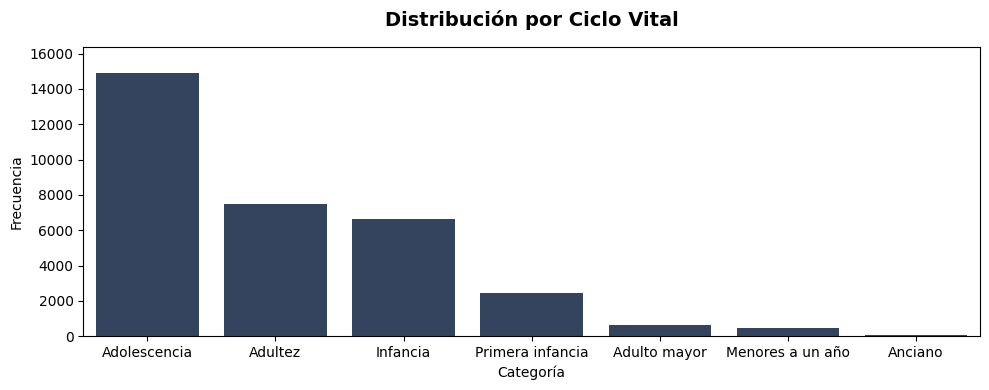

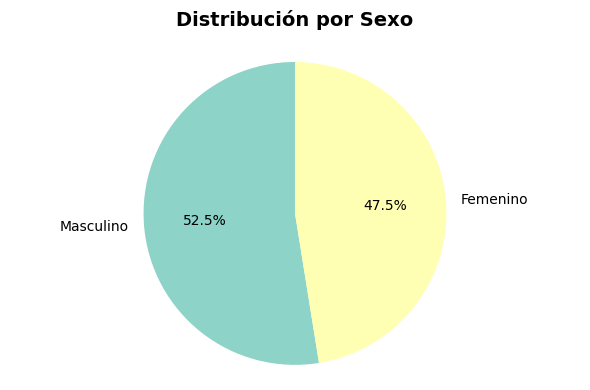

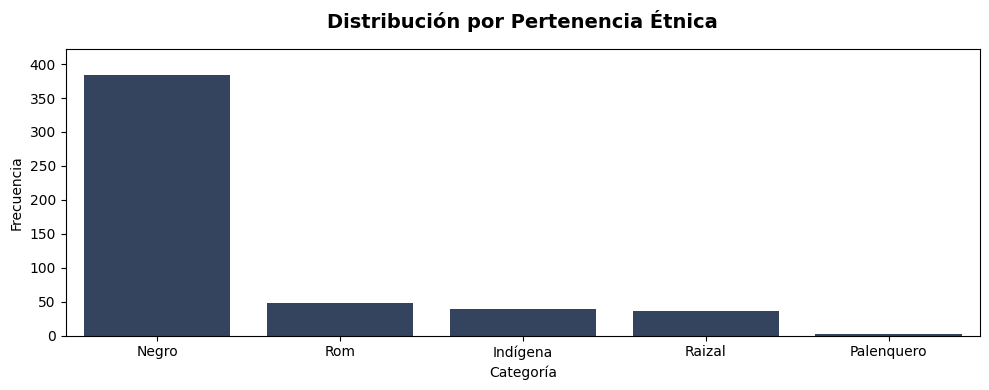

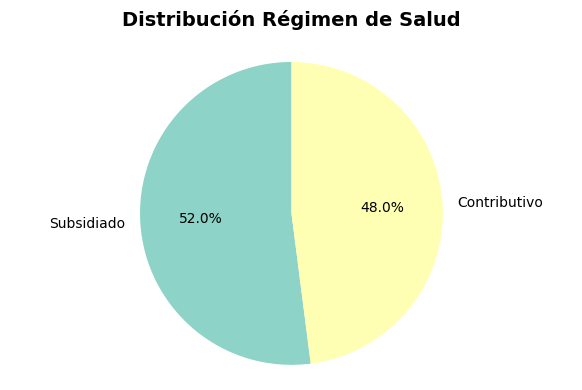

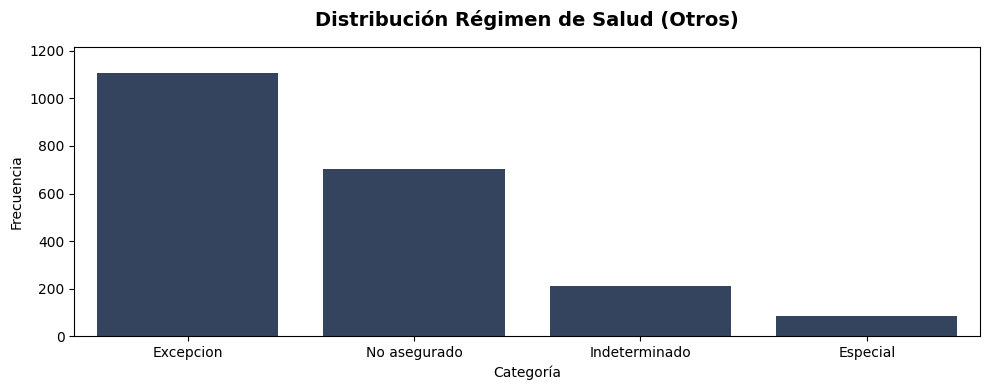

In [10]:
graficar_categorica("ciclo_vital", "Distribución por Ciclo Vital", df)
graficar_categorica_pie("sexo", "Distribución por Sexo", df)

etnia_filtrada = df[df["pertenencia_etnica"] != "Otro"]
graficar_categorica('pertenencia_etnica', "Distribución por Pertenencia Étnica", etnia_filtrada)

df_regimen_principal = df[df["regimen_salud"].isin(["Contributivo", "Subsidiado"])]
df_regimen_otros = df[~df["regimen_salud"].isin(["Contributivo", "Subsidiado"])]
graficar_categorica_pie("regimen_salud", "Distribución Régimen de Salud", df_regimen_principal)
graficar_categorica("regimen_salud", "Distribución Régimen de Salud (Otros)", df_regimen_otros)

* Edad

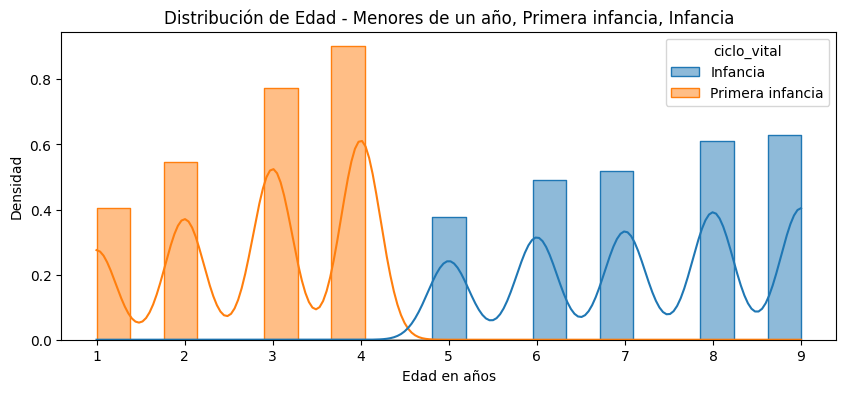

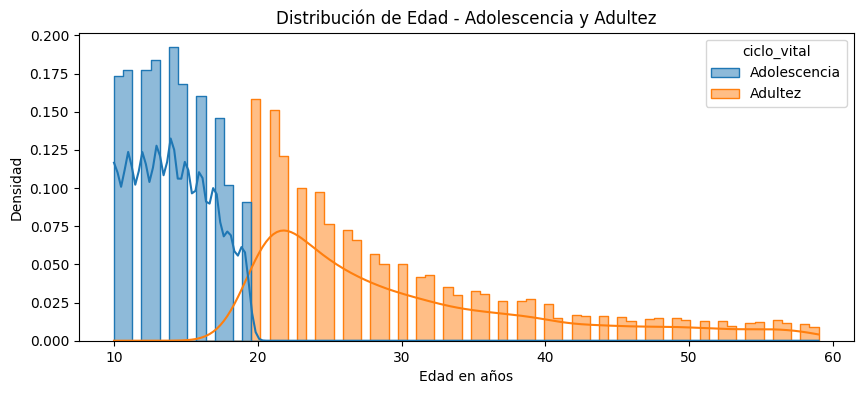

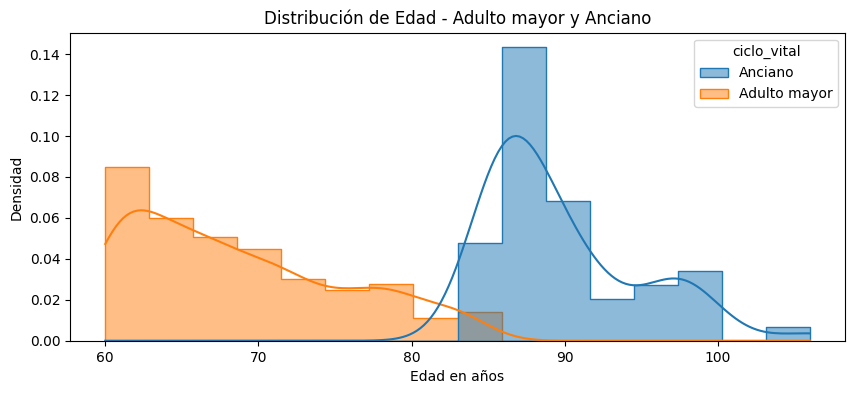

In [11]:
# Grupo 1: menores de un año, primera infancia, infancia
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df[df["ciclo_vital"].isin(["Menores de un año", "Primera infancia", "Infancia"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Menores de un año, Primera infancia, Infancia")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()

# Grupo 2: adolescencia y adultez
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df[df["ciclo_vital"].isin(["Adolescencia", "Adultez"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Adolescencia y Adultez")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()

# Grupo 3: adulto mayor y anciano
plt.figure(figsize=(10, 4))
sns.histplot(
    data=df[df["ciclo_vital"].isin(["Adulto mayor", "Anciano"])],
    x="edad_años",
    hue="ciclo_vital",
    kde=True,
    stat="density",
    common_norm=False,
    element="step",
    alpha=0.5
)
plt.title("Distribución de Edad - Adulto mayor y Anciano")
plt.xlabel("Edad en años")
plt.ylabel("Densidad")
plt.show()


In [12]:
tabla_resumen = df.groupby("ciclo_vital")["edad_años"].describe()
tabla_resumen

,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,14894.0,14.015778,2.680449,10.0,12.0,14.0,16.0,19.0
Adultez,7471.0,30.158346,10.104379,20.0,22.0,27.0,35.0,59.0
Adulto mayor,623.0,68.624398,6.893786,60.0,63.0,67.0,73.0,84.0
Anciano,51.0,89.803922,4.988064,85.0,86.0,88.0,91.5,106.0
Infancia,6643.0,7.238748,1.376959,5.0,6.0,7.0,8.0,9.0
Menores a un año,445.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Primera infancia,2467.0,2.826510,1.067424,1.0,2.0,3.0,4.0,4.0


In [13]:
# Tabla para evento Clásico
tabla_clasico = df[df["evento"] == "Clasico"].groupby("ciclo_vital")["edad_años"].describe()

# Tabla para evento Grave
tabla_grave = df[df["evento"] == "Grave"].groupby("ciclo_vital")["edad_años"].describe()

print("📌 Evento: Clasico")
tabla_clasico

📌 Evento: Clasico


,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,14531.0,14.005230,2.679092,10.0,12.0,14.0,16.0,19.0
Adultez,7265.0,30.179215,10.111743,20.0,22.0,27.0,35.0,59.0
Adulto mayor,594.0,68.612795,6.939019,60.0,63.0,67.0,73.0,84.0
Anciano,45.0,89.644444,4.987054,85.0,86.0,88.0,91.0,106.0
Infancia,6531.0,7.233961,1.377488,5.0,6.0,7.0,8.0,9.0
Menores a un año,436.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Primera infancia,2423.0,2.822121,1.067177,1.0,2.0,3.0,4.0,4.0


In [14]:
print("📌 Evento: Grave")
tabla_grave


📌 Evento: Grave


,count,mean,std,min,25%,50%,75%,max
ciclo_vital,,,,,,,,
Adolescencia,363.0,14.438017,2.704281,10.0,12.00,14.0,17.0,19.0
Adultez,206.0,29.422330,9.836779,20.0,22.00,26.0,34.0,58.0
Adulto mayor,29.0,68.862069,5.992401,61.0,65.00,68.0,73.0,82.0
Anciano,6.0,91.000000,5.291503,85.0,86.75,90.5,95.0,98.0
Infancia,112.0,7.517857,1.321902,5.0,6.00,8.0,9.0,9.0
Menores a un año,9.0,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0
Primera infancia,44.0,3.068182,1.065260,1.0,2.75,3.0,4.0,4.0


### 2.2 Variables de evento



In [15]:
describir_categorica(df['evento'])
describir_categorica(df['tipo_de_caso'])
describir_categorica(df['hospitalizado'])
describir_categorica(df['muerte'])


📌 Variable: evento
         Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
evento                                                               
Clasico   31825      0.9764    31825      0           1.0         0.0
Grave       769      0.0236        0    769           0.0         1.0

-----------------------------------

📌 Variable: tipo_de_caso
                        Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
tipo_de_caso                                                               
Probable                 21959      0.6737    21420    539        0.9755   
Confirmado Laboratorio   10546      0.3236    10316    230        0.9782   
Confirmado por Nexo         89      0.0027       89      0        1.0000   

                        Prop_Grave  
tipo_de_caso                        
Probable                    0.0245  
Confirmado Laboratorio      0.0218  
Confirmado por Nexo         0.0000  

-----------------------------------

📌 Variable: hospitalizado
       

### 2.3 Variables temporales

In [16]:
describir_categorica(df["año"])


📌 Variable: año
      Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
año                                                               
2022   10481      0.3216    10148    333        0.9682      0.0318
2021    7851      0.2409     7663    188        0.9761      0.0239
2019    3963      0.1216     3905     58        0.9854      0.0146
2018    3293      0.1010     3246     47        0.9857      0.0143
2023    3154      0.0968     3093     61        0.9807      0.0193
2020    2656      0.0815     2613     43        0.9838      0.0162
2017    1196      0.0367     1157     39        0.9674      0.0326

-----------------------------------


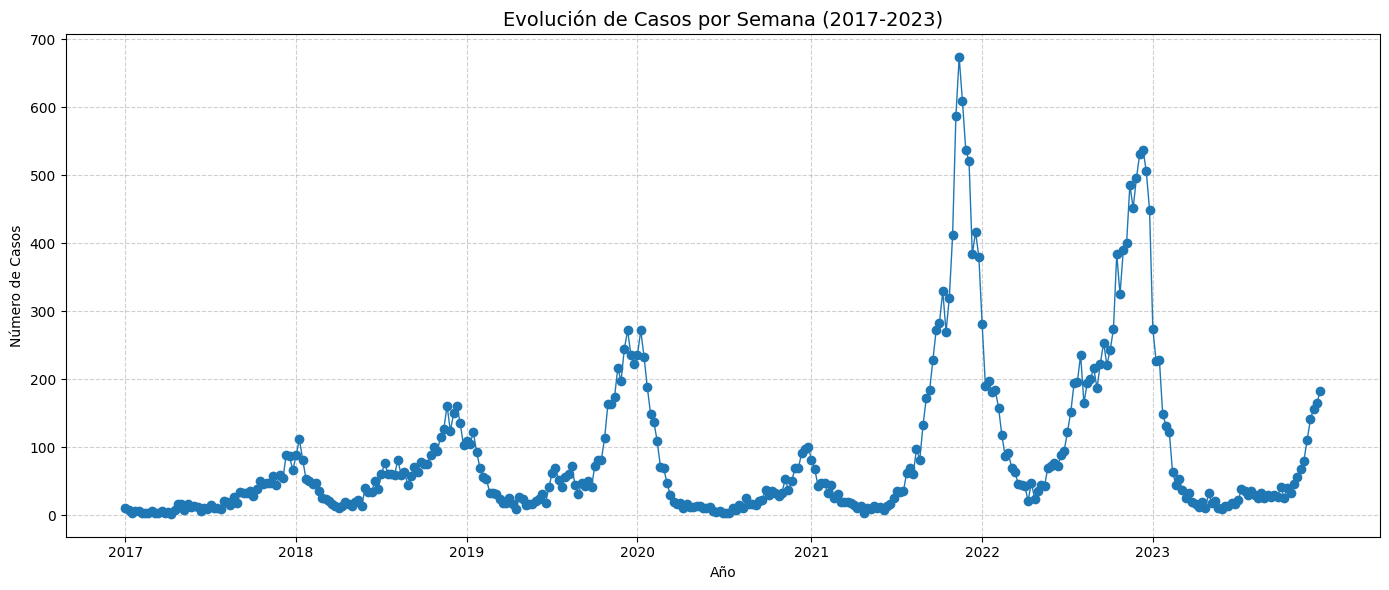

In [17]:
# Agrupar por año y semana
casos_semana = df.groupby(["año", "semana"]).size().reset_index(name="casos")

# Ordenar
casos_semana = casos_semana.sort_values(["año", "semana"]).reset_index(drop=True)

# Crear índice continuo
casos_semana["index"] = range(len(casos_semana))

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(casos_semana["index"], casos_semana["casos"], marker="o", linewidth=1)

# Marcar solo los años en el eje X
años_unicos = casos_semana["año"].unique()
ticks = [casos_semana[casos_semana["año"] == año].index[0] for año in años_unicos]
plt.xticks(ticks, años_unicos, fontsize=10)

plt.title("Evolución de Casos por Semana (2017-2023)", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Número de Casos")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### 2.4 Variables espaciales

In [18]:
describir_categorica(df["area"])
describir_categorica(df['municipio'])


📌 Variable: area
                    Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
area                                                                   
Cabecera municipal   32006      0.9820    31251    755        0.9764   
Centro poblado         517      0.0159      504     13        0.9749   
Rural disperso          71      0.0022       70      1        0.9859   

                    Prop_Grave  
area                            
Cabecera municipal      0.0236  
Centro poblado          0.0251  
Rural disperso          0.0141  

-----------------------------------

📌 Variable: municipio
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
municipio                                                                     
BARRANQUILLA       19681      0.6038    19274    407        0.9793      0.0207
SOLEDAD             5747      0.1763     5611    136        0.9763      0.0237
MALAMBO             1539      0.0472     1499     40        0.9740      0.0260
S

## Exploración binaria

## 3. MAPAS

In [19]:
import geopandas as gpd

In [20]:
# Casos de dengue
df = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\data_atlantico.csv", encoding='latin_1', low_memory=False)
df.columns = df.columns.str.upper()

# Población proyectada
poblacion = pd.read_csv(r"C:\Users\Hp\DENGUE\Data\dengue_data\Poblacion_atl.csv", encoding='latin_1', low_memory=False)

# Shapefile de Atlántico
gdf = gpd.read_file(r"C:\Users\Hp\DENGUE\Data\dengue_data\atlantico_municipios.shp")


In [21]:
# Agrupamos casos por municipio, año y evento
casos = df.groupby(["MUNICIPIO", "AÑO", "EVENTO"]).size().reset_index(name="casos")

# Total acumulado (sin año, solo municipio y evento)
casos_total = df.groupby(["MUNICIPIO", "EVENTO"]).size().reset_index(name="casos")


In [22]:
# Estandarizamos nombres
casos["MUNICIPIO"] = casos["MUNICIPIO"].str.upper().str.strip()
casos_total["MUNICIPIO"] = casos_total["MUNICIPIO"].str.upper().str.strip()
gdf["MUNICIPIO"] = gdf["mpio_cnmbr"].str.upper().str.strip()


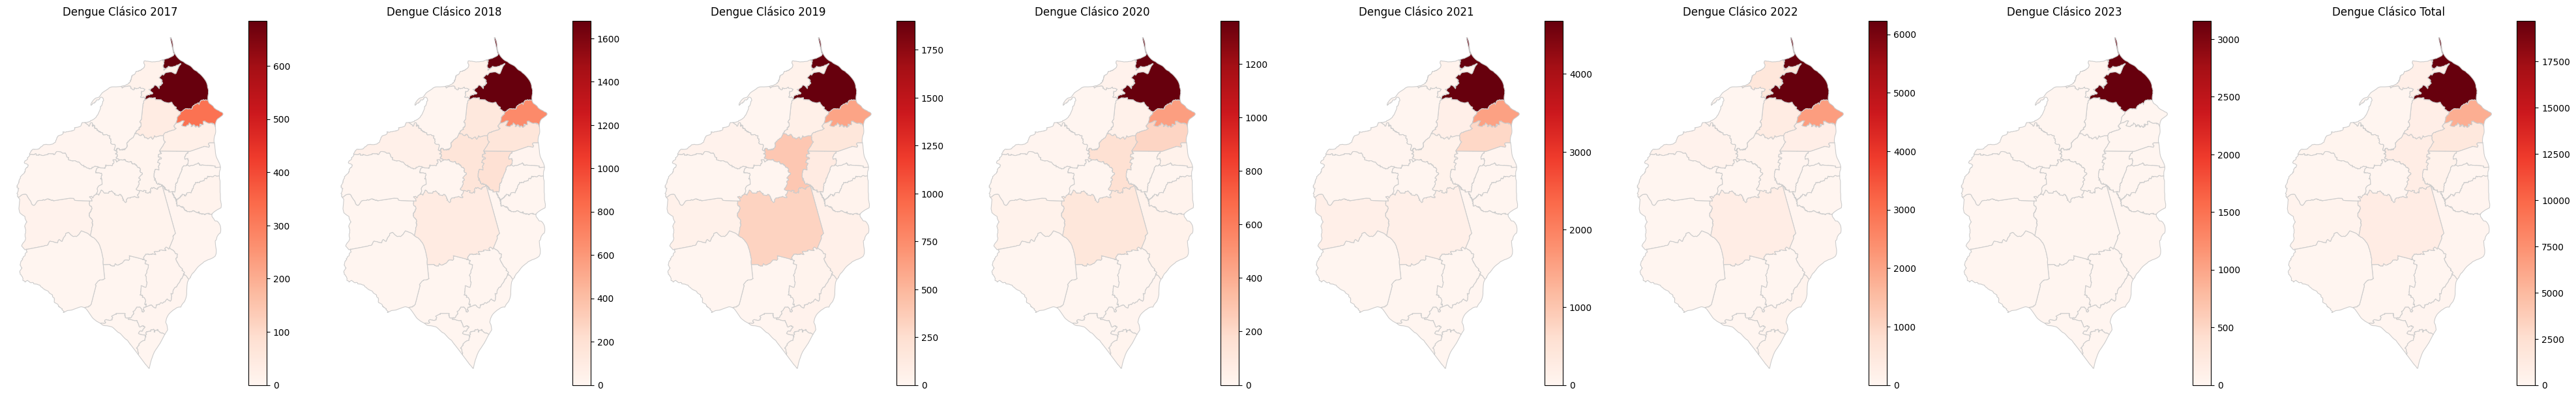

In [23]:
# Lista de años
anios = sorted(df["AÑO"].unique())
n = len(anios) + 1  # años + total

fig, axes = plt.subplots(1, n, figsize=(5*n, 6))

for i, anio in enumerate(anios):
    casos_anio = df[df["AÑO"] == anio]
    casos_anio = casos_anio.groupby("MUNICIPIO").size().reset_index(name="CASOS")
    gdf_plot = gdf.merge(casos_anio, on="MUNICIPIO", how="left").fillna(0)
    
    gdf_plot.plot(column="CASOS", cmap="Reds", linewidth=0.8, edgecolor="0.8",
                  legend=True, ax=axes[i])
    axes[i].set_title(f"Dengue Clásico {anio}")
    axes[i].axis("off")

# Total de casos
casos_total = df.groupby("MUNICIPIO").size().reset_index(name="CASOS")
gdf_total = gdf.merge(casos_total, on="MUNICIPIO", how="left").fillna(0)

gdf_total.plot(column="CASOS", cmap="Reds", linewidth=0.8, edgecolor="0.8",
               legend=True, ax=axes[-1])
axes[-1].set_title("Dengue Clásico Total")
axes[-1].axis("off")

plt.tight_layout()
plt.show()


In [24]:
import pandas as pd

# Merge por municipio y año
df = pd.merge(df, poblacion, on=['MUNICIPIO','AÑO'], how='left')


In [25]:
df['tasa_incidencia'] = (casos / df['POBLACION']) * 100000

df_global = df.groupby('año').agg({'casos':'sum','poblacion':'sum'}).reset_index()
df_global['tasa_incidencia'] = (df_global['casos'] / df_global['poblacion']) * 100000

df_sorted = df.sort_values(['año','tasa_incidencia'], ascending=[True, False])


KeyError: 'POBLACION'

4. Exploración bivariada (comparaciones)

4.1 Demografía vs evento/desenlace

Edad × hospitalización.

Sexo × tipo de caso.

Aseguradora × mortalidad.

4.2 Geografía vs desenlace

Municipios/localidades con mayor hospitalización o mortalidad.

Tasas de casos por 100.000 hab.

4.3 Temporalidad vs desenlace

Hospitalización y mortalidad por año y semana.

Comparaciones antes/después de picos epidémicos.

5. Pruebas estadísticas

Pruebas de proporción:

Diferencia en proporciones de hospitalización por sexo.

Diferencia en proporciones de mortalidad entre municipios/localidades.

Chi-cuadrado de independencia:

Sexo × tipo de caso.

Edad (categorías) × hospitalización.

Municipio × mortalidad.

Pruebas de medias:

Diferencia en promedio de edad entre hospitalizados vs no hospitalizados.

Diferencia en diferencia de días (síntomas→consulta) por municipio.

6. Análisis multivariado

Correlación entre variables numéricas

Edad, diferencia de días, semana.

Heatmap de correlaciones.

Análisis de correspondencias múltiples (ACM/MCA)

Para variables categóricas: sexo, etnia, aseguradora, municipio/localidad.

Ver si aparecen perfiles de pacientes.

Clustering exploratorio (opcional)

Agrupar barrios/localidades por perfil de casos.

7. Resumen y hallazgos clave

Principales patrones encontrados.

Variables críticas para explicar hospitalización y mortalidad.

Brechas de información (faltantes o inconsistencias).